Investigating stylized facts of asset returns
Stylized facts are statistical properties that are present in many empirical asset returns (across time and markets). It is important to be aware of them because when we are building models that are supposed to represent asset price dynamics, the models should be able to capture/replicate these properties.

Importing relevant libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt


data = pd.read_csv("/content/btc_dataset.csv")


# feature extraction


In [24]:
# Drop 'unix' and 'symbol' columns
data = data.drop(columns=['unix', 'symbol'])

# Print the first few rows of the dataframe to confirm
data.head()

,date,open,high,low,close,Volume BTC,Volume USD
0,09/06/2023 00:00,26507.0,26522.0,26493.0,26493.0,14.065790,3.726450e+05
1,08/06/2023 23:00,26547.0,26565.0,26498.0,26510.0,13.001130,3.446599e+05
2,08/06/2023 22:00,26571.0,26609.0,26536.0,26554.0,29.344521,7.792144e+05
3,08/06/2023 21:00,26644.0,26651.0,26555.0,26577.0,41.871368,1.112815e+06
4,08/06/2023 20:00,26537.0,26653.0,26522.0,26643.0,110.133306,2.934282e+06


In [27]:
columns = ['date','open', 'high', 'low', 'close', 'Volume USD']
statistics = data[columns].describe()
print(statistics)

               open          high           low         close    Volume USD
count  44419.000000  44419.000000  44419.000000  44419.000000  4.441900e+04
mean   21480.556969  21590.350107  21362.775785  21481.026110  2.804578e+06
std    16674.144532  16768.575754  16571.949239  16674.196307  6.560232e+06
min     3139.760000   3158.340000   3122.280000   3139.760000  0.000000e+00
25%     7924.585000   7961.530000   7881.615000   7924.585000  2.369850e+02
50%    16520.000000  16559.000000  16478.000000  16522.000000  4.708008e+05
75%    33258.490000  33516.835000  32932.195000  33251.215000  2.938296e+06
max    68635.050000  69000.000000  68447.000000  68627.010000  2.582324e+08


Fact 1: Non-Gaussian distribution of returns



In [28]:
# Convert 'date' column to datetime and set it as index if 'date' is not the index
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)



<ipython-input-29-e409ad4eb16e>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.log_rtn.dropna(), kde=False,


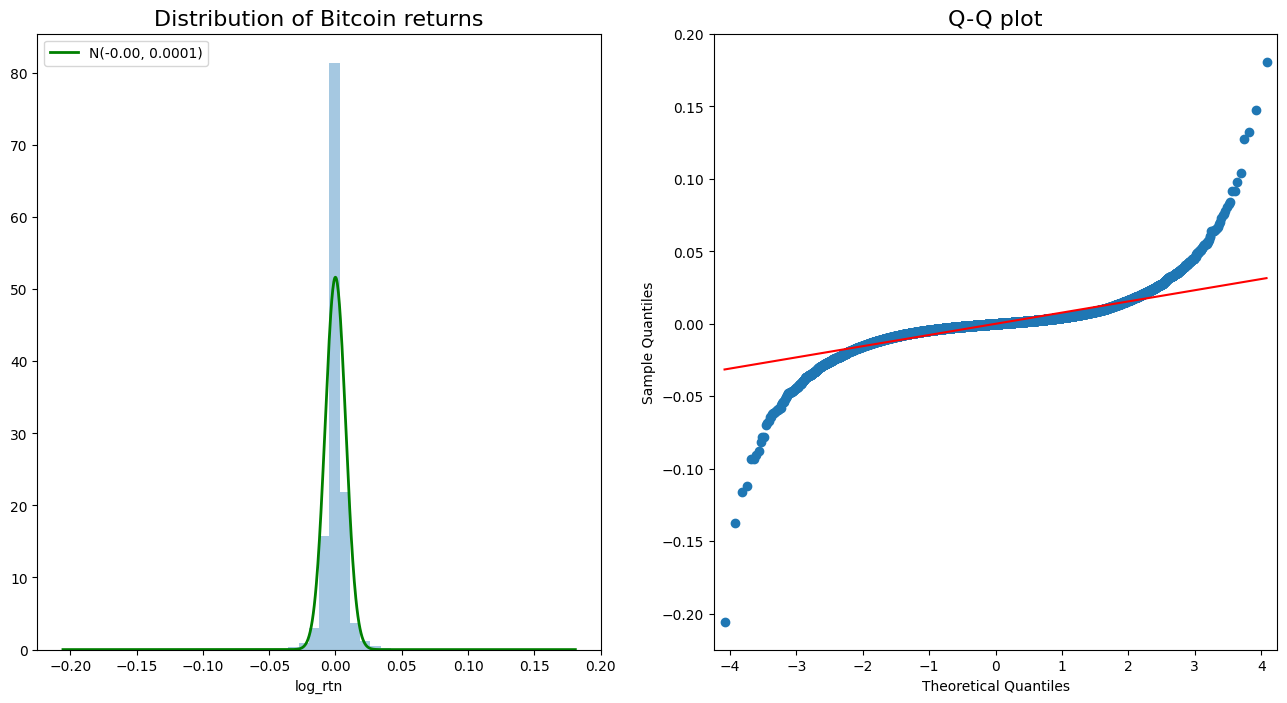

In [29]:
# Calculate the logarithmic returns
data["log_rtn"] = np.log(data["close"] / data["close"].shift(1))

# Calculate range, mu, and sigma for the normal distribution
r_range = np.linspace(min(data["log_rtn"].dropna()),
                      max(data["log_rtn"].dropna()),
                      num=1000)
mu = data["log_rtn"].mean()
sigma = data["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

# Create the plots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Histogram
sns.distplot(data.log_rtn.dropna(), kde=False,
             norm_hist=True, ax=ax[0])
ax[0].set_title("Distribution of Bitcoin returns",
                fontsize=16)
ax[0].plot(r_range, norm_pdf, "g", lw=2,
           label=f"N({mu:.2f}, {sigma**2:.4f})")
ax[0].legend(loc="upper left")

# Q-Q plot
sm.qqplot(data.log_rtn.dropna(), line="s", ax=ax[1])
ax[1].set_title("Q-Q plot", fontsize=16)

plt.show()


**Fact 2: Volatility clustering**

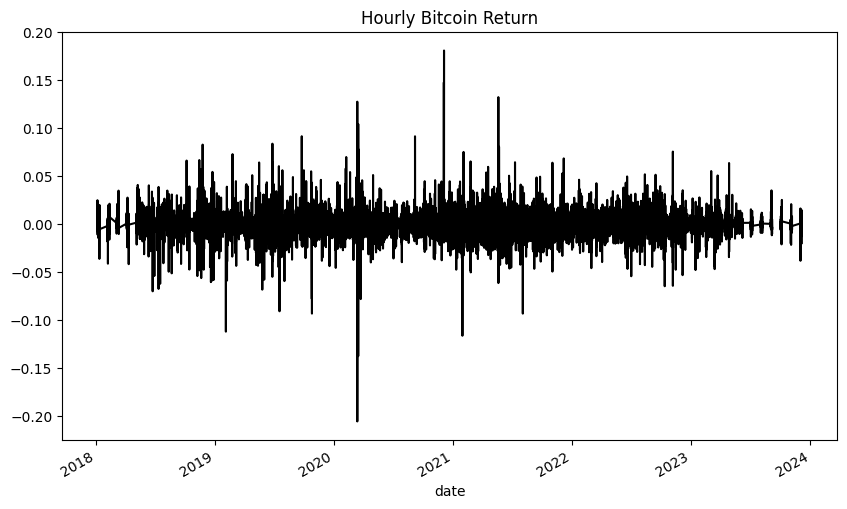

In [30]:
# Plotting the logarithmic returns
data["log_rtn"].plot(title="Hourly Bitcoin Return", color="black", figsize=(10, 6))
plt.show()


**Fact 3: Absence of autocorrelation in returns**

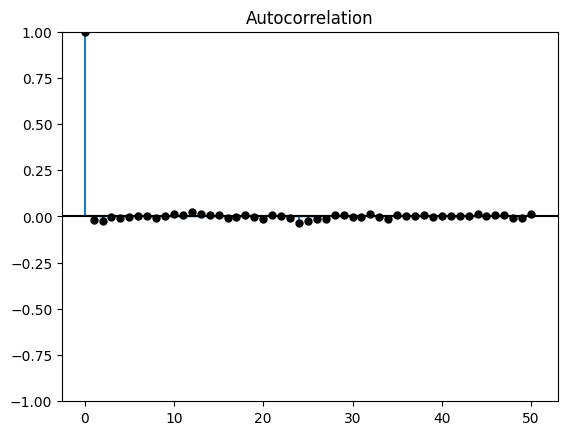

In [39]:
# Calculate the logarithmic returns
data["log_rtn"] = np.log(data["close"] / data["close"].shift(1))

# Define the number of lags and the significance level
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

# Plot the autocorrelation function
acf = smt.graphics.plot_acf(data["log_rtn"].dropna(), lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, color='black')
plt.show()

**Fact 4: Small and decreasing autocorrelation in squared/absolute returns**

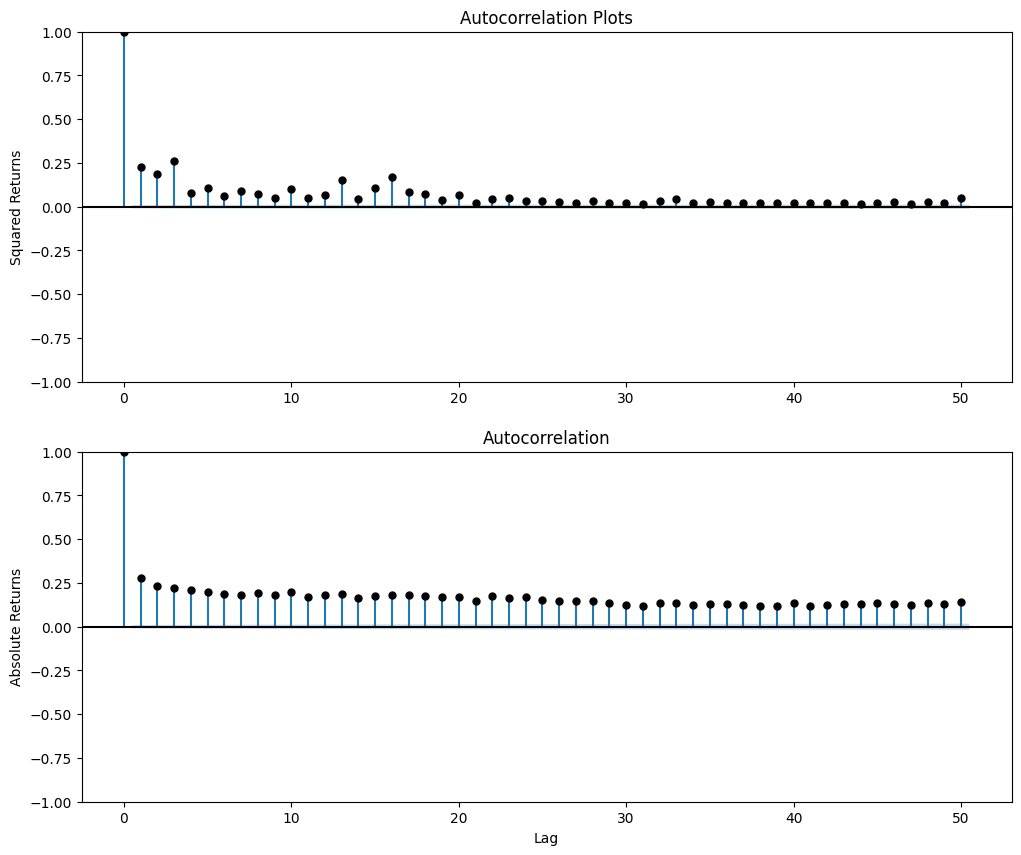

In [40]:
# Autocorrelation plots
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
smt.graphics.plot_acf(data["log_rtn"].dropna()**2, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[0], color='black')
ax[0].set(title="Autocorrelation Plots",
          ylabel="Squared Returns")
smt.graphics.plot_acf(np.abs(data["log_rtn"].dropna()), lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[1], color='black')
ax[1].set(ylabel="Absolute Returns",
          xlabel="Lag")
plt.show()


**Fact 5: Leverage effect**

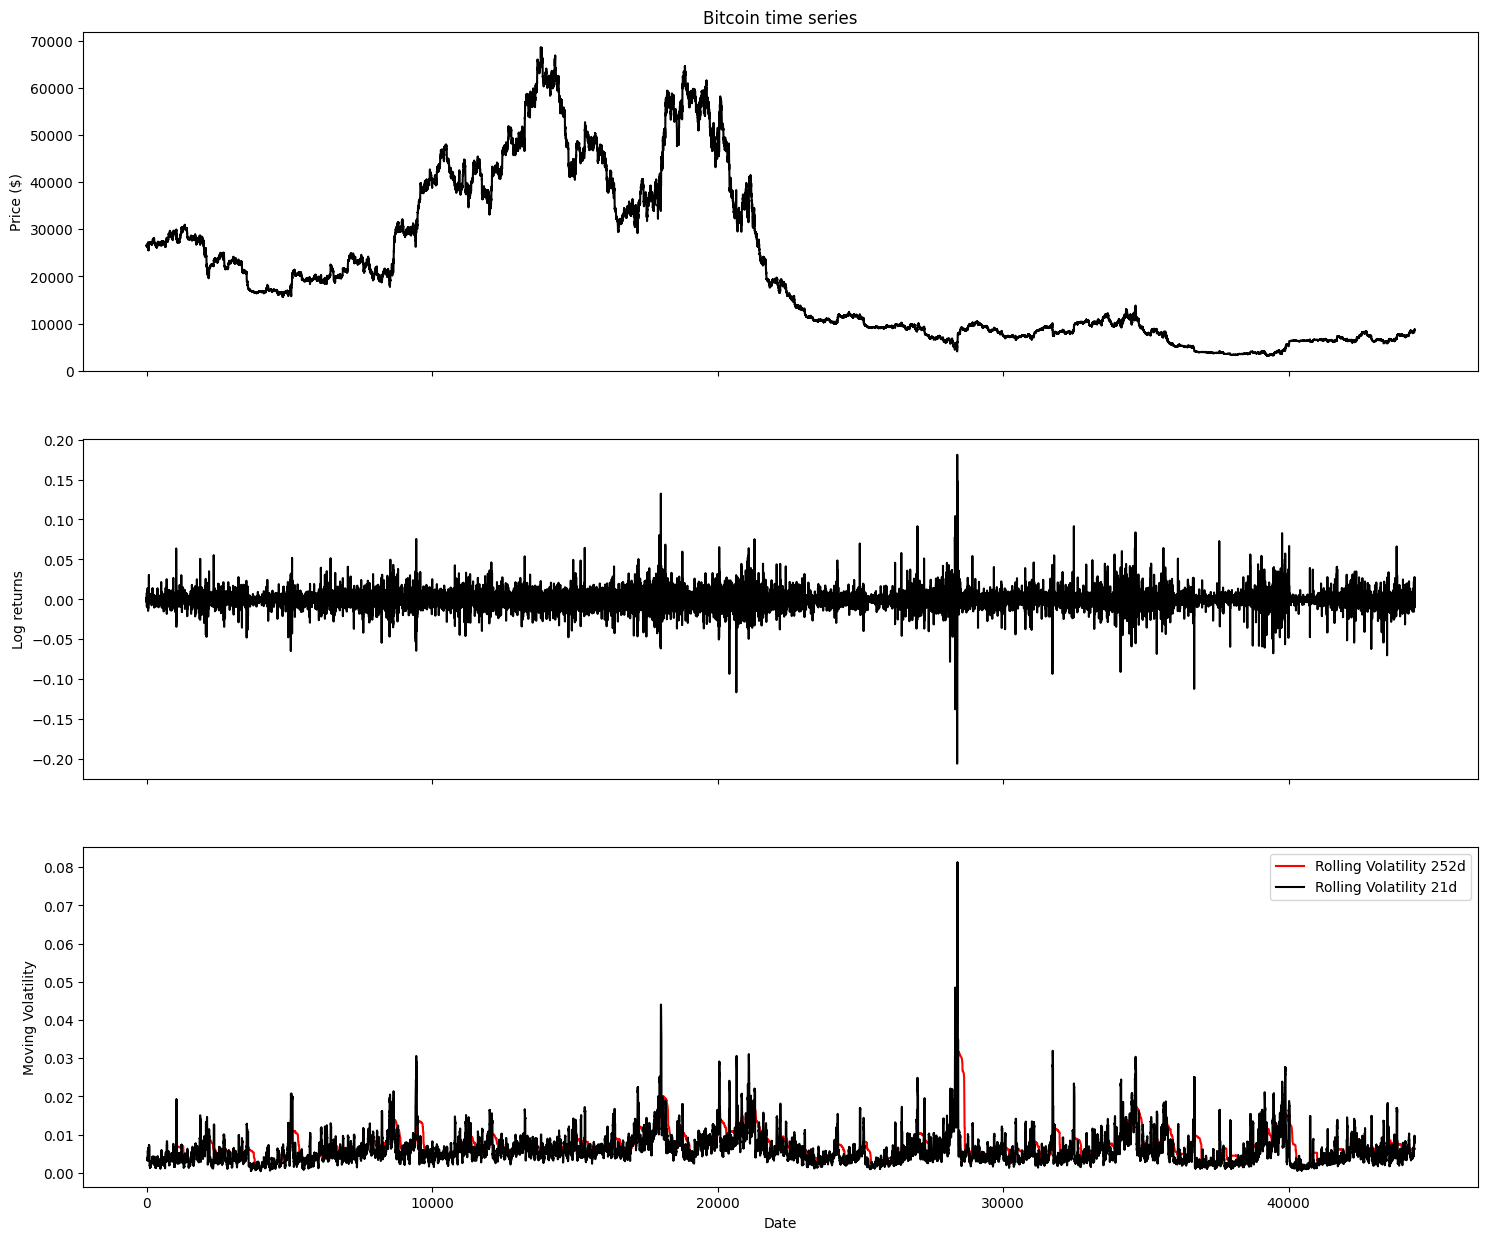

In [48]:
# Calculate the moving standard deviations
data["moving_std_252"] = data["log_rtn"].rolling(window=252).std()
data["moving_std_21"] = data["log_rtn"].rolling(window=21).std()

# Price, returns, and moving volatilities plots with black and red color
fig, ax = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
data["close"].plot(ax=ax[0], color='black')
ax[0].set(title="Bitcoin time series",
          ylabel="Price ($)")
data["log_rtn"].plot(ax=ax[1], color='black')
ax[1].set(ylabel="Log returns")
data["moving_std_252"].plot(ax=ax[2], color="red",
                           label="Rolling Volatility 252d")
data["moving_std_21"].plot(ax=ax[2], color="black",
                           label="Rolling Volatility 21d")
ax[2].set(ylabel="Moving Volatility",
          xlabel="Date")
ax[2].legend()
plt.show()
